In [57]:
device = "cpu"
font_file = "/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf"

In [103]:
min_accuracy

0.9

In [58]:
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2

segment_weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
segment_model = maskrcnn_resnet50_fpn_v2(weights=segment_weights)
segment_transforms = segment_weights.transforms()

segment_model.eval().to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [59]:
### Load Human Keypoint Detection Model

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

kp_weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
kp_model =  keypointrcnn_resnet50_fpn(weights=kp_weights)
kp_transforms = kp_weights.transforms()

kp_model.eval().to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [60]:
### Definte VIDEO loading Functions
import os
import av 
import math
import random

from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

def load_video(video_path, rotate_angle, frame_position):
    video, audio, meta = read_video(
        video_path,
        pts_unit="sec",
        output_format="TCHW"
    )

    frame_counts = len(video)
    fps = meta['video_fps']
    sample_index = frame_position
    sample_frame = to_pil_image(video[sample_index])
    sample_frame = sample_frame.rotate(rotate_angle, expand=True)
    return video, frame_counts, fps, sample_frame

In [129]:
### Define Visualization FUNCTIONS

from PIL import ImageDraw, ImageFont

marker_font = ImageFont.truetype(font_file, 8)
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

def center(bbox):
    center_x = (bbox[2] + bbox[0])/2
    center_y = (bbox[3] + bbox[1])/2
    center = [center_x, center_y]
    return center

def dtb(bbox1, bbox2):
    print(bbox1)
    print(bbox2)
    bbox1_center = center(bbox1)
    bbox2_center = center(bbox2)
    x_dif = bbox1_center[0] - bbox2_center[0]
    y_dif = bbox1_center[1] - bbox2_center[1]
    
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    return distance

def dfc(pic, bbox):
    pic_width = pic.width
    pic_height = pic.height
    
    pic_center = center([0,0, pic_width, pic_height])
    bbox_center = center(bbox)
    
    x_dif = bbox_center[0] - pic_center[0]
    y_dif = bbox_center[1] - pic_center[1]
    bbox_width = bbox[2] - bbox[0]
    bbox_height = bbox[3] - bbox[1] 
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    area = abs(bbox_width * bbox_height)
    return distance, area

def getSHAPositions(kp):
    ls = kp[0][5]
    rs = kp[0][6]
    
    lw = kp[0][9]
    rw = kp[0][10]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]
    
    points = [
        [ls[0].item(), ls[1].item()],
        [rs[0].item(), rs[1].item()],
        [lw[0].item(), lw[1].item()],
        [rw[0].item(), rw[1].item()],
        [lh[0].item(), lh[1].item()], 
        [rh[0].item(), rh[1].item()], 
        [la[0].item(), la[1].item()], 
        [ra[0].item(), ra[1].item()]
    ]
    
    return points

def drawMarkers(labels, coordinates, image):
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 
            
    for index, point in zip(labels, coordinates):
        label = index 
        radius = 6

        draw.ellipse(
            [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)],
            fill="#40389F",
            outline="#ffffff",
            width=1
        )

        draw.text(
            (point[0]-3, point[1]-6),
            str(label),
            fill="#FAFF00",
            font=marker_font,
            align="center"
        )
    return sample

In [147]:
## Definte Keypoint detection Functions

import torch

def detect(frame):
    ### Make Predictions on Frame
    body_matrix = kp_transforms(frame)
    predictions = kp_model([body_matrix.to(device)])
    
    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']

    
    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_accuracy)
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 10
    max_area = 0
    min_distance = math.sqrt(frame.width/2 * frame.width/2 + frame.height/2 * frame.height/2)
    print("Found ", len(main_boxes), " person in the frame")
    selected_bbox = []
    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < min_distance:
           if area < max_area/2:
               pass
           else:
               max_area = area
               min_distance = distance
               index = selector
               selected_bbox = bbox

    print("Select keypoint index", index)
    bx = torch.unsqueeze(boxes[idx][index], dim=0)
    kp = torch.unsqueeze(keypoints[idx][index], dim=0)
    SHApoints = getSHAPositions(kp)

    labels = ["ls","rs","lw", "rw", "lh","rh","la","ra"]
    points_image = drawMarkers(labels, SHApoints, frame)

    return points_image, SHApoints, selected_bbox

In [132]:
### Define Segmentation and Mask Conversion Functions

import torch
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import numpy as np

def segment(frame, selected_bbox):
    ### Run Predicion Model to find Mask
    input_image = segment_transforms(frame)
    predictions = segment_model([input_image.to(device)])
    masks = predictions[0]['masks']
    scores = predictions[0]['scores']
    boxes = predictions[0]['boxes']
    idx = torch.where(scores > min_accuracy)
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    max_distance = 10

    print("Found ", len(main_boxes), " person in the frame")

    index = 10
    
    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance_from_selected = dtb(bbox, selected_bbox)
        
        if distance_from_selected > max_distance:
            print("Not selected", distance_from_selected)
            pass
        else:
            print("Selected", selector)
            index = selector
               
              
    #print("Found "+str(len(masks))+" mask with scores ",str(scores))
    print("Select mask index", index)
    mask = torch.squeeze(masks[index][0], dim=1)
    mask_image = to_pil_image(mask)
    
    ### Find the Minimum Pixel Threshold for Mask
    numpy_mask = mask.detach().cpu().numpy()
    counts, values = np.histogram(numpy_mask, bins=10)
    min_counts = np.min(counts)
    idx = np.where(counts == min_counts)
    threshold = values[idx] 
    numpy_bool_mask = numpy_mask > threshold
    bool_mask = torch.tensor(numpy_bool_mask)
    
    return mask, mask_image, bool_mask

In [154]:
output_dir = "/Users/troydo42/Desktop"
video_file = "/Users/troydo42/Desktop/VID_20230102_171533_2.mp4"
min_accuracy = 0.9
frame_pos = 37
sample_name = str(frame_pos)+"_"+video_file[-10:-4]

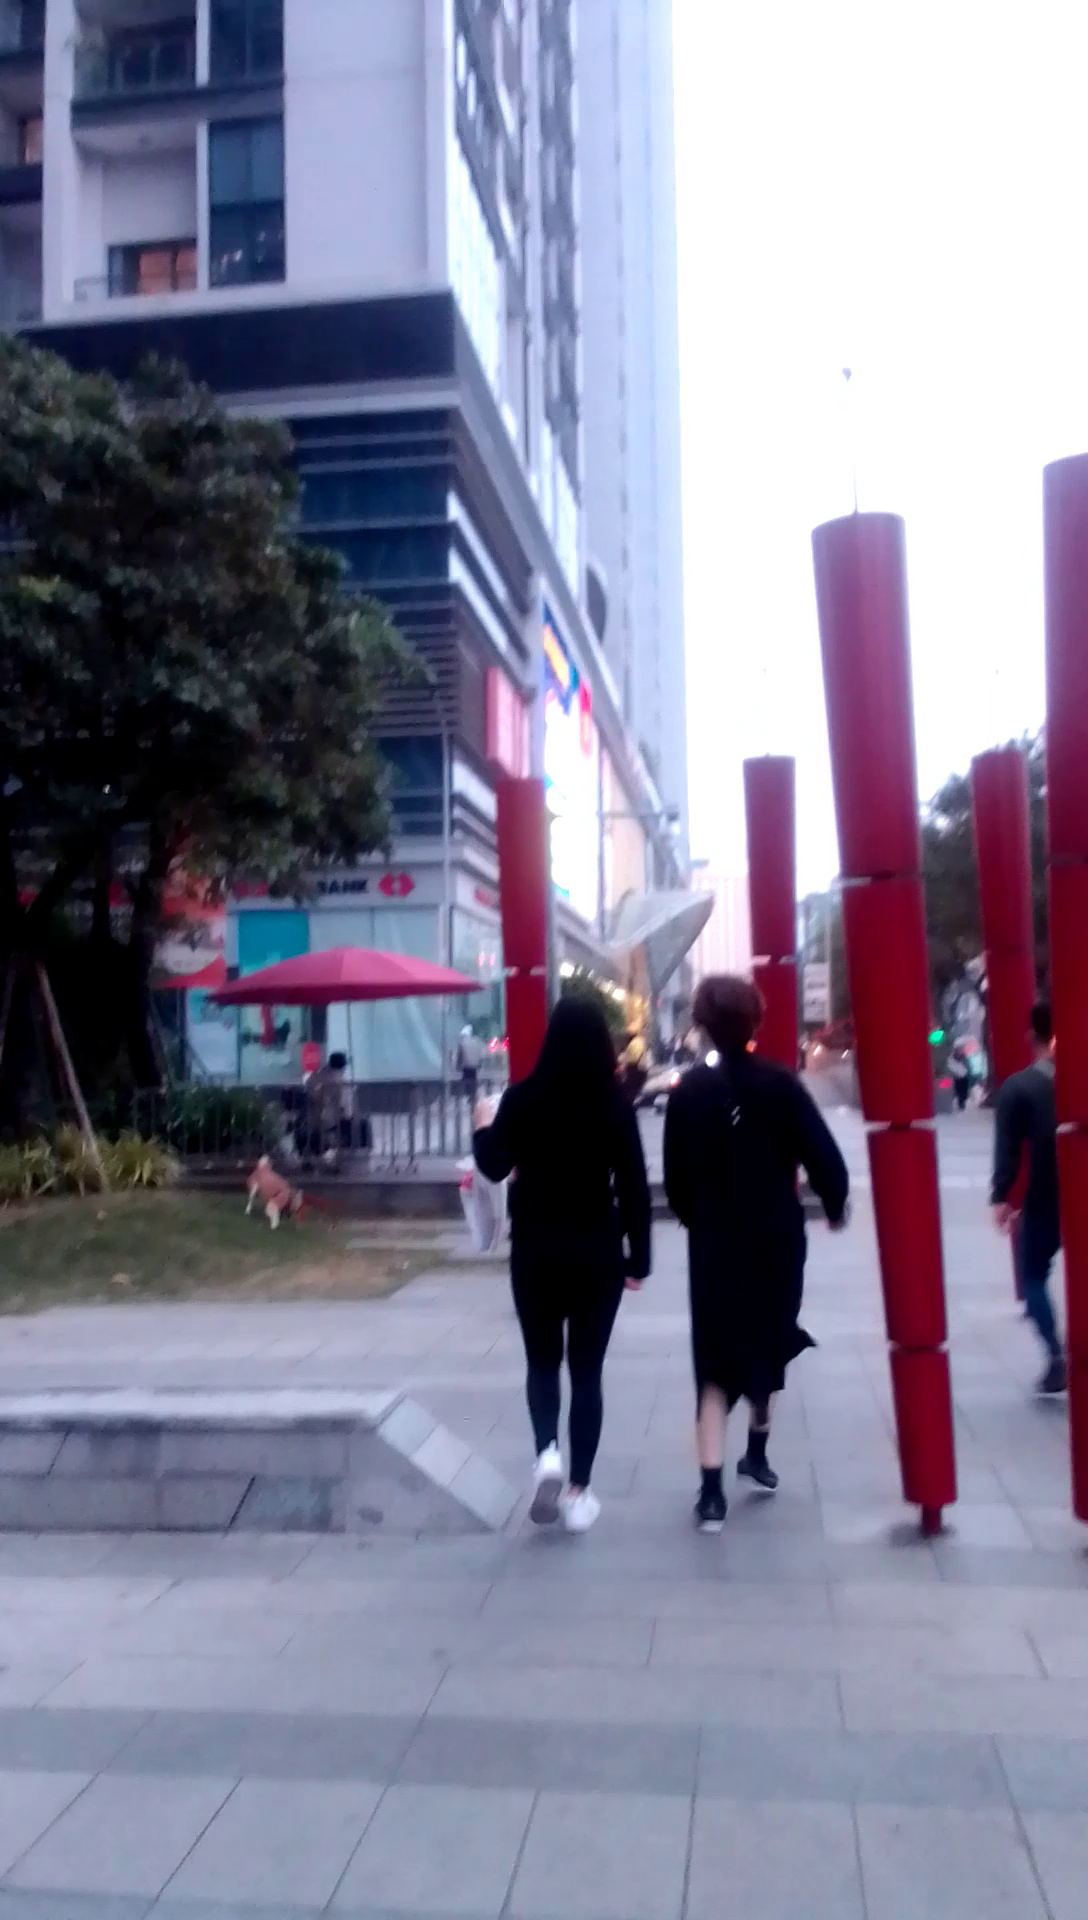

In [155]:
vid, counts, fps, sample = load_video(video_file, -90, frame_pos)
sample

Found  4  person in the frame
Select keypoint index 1


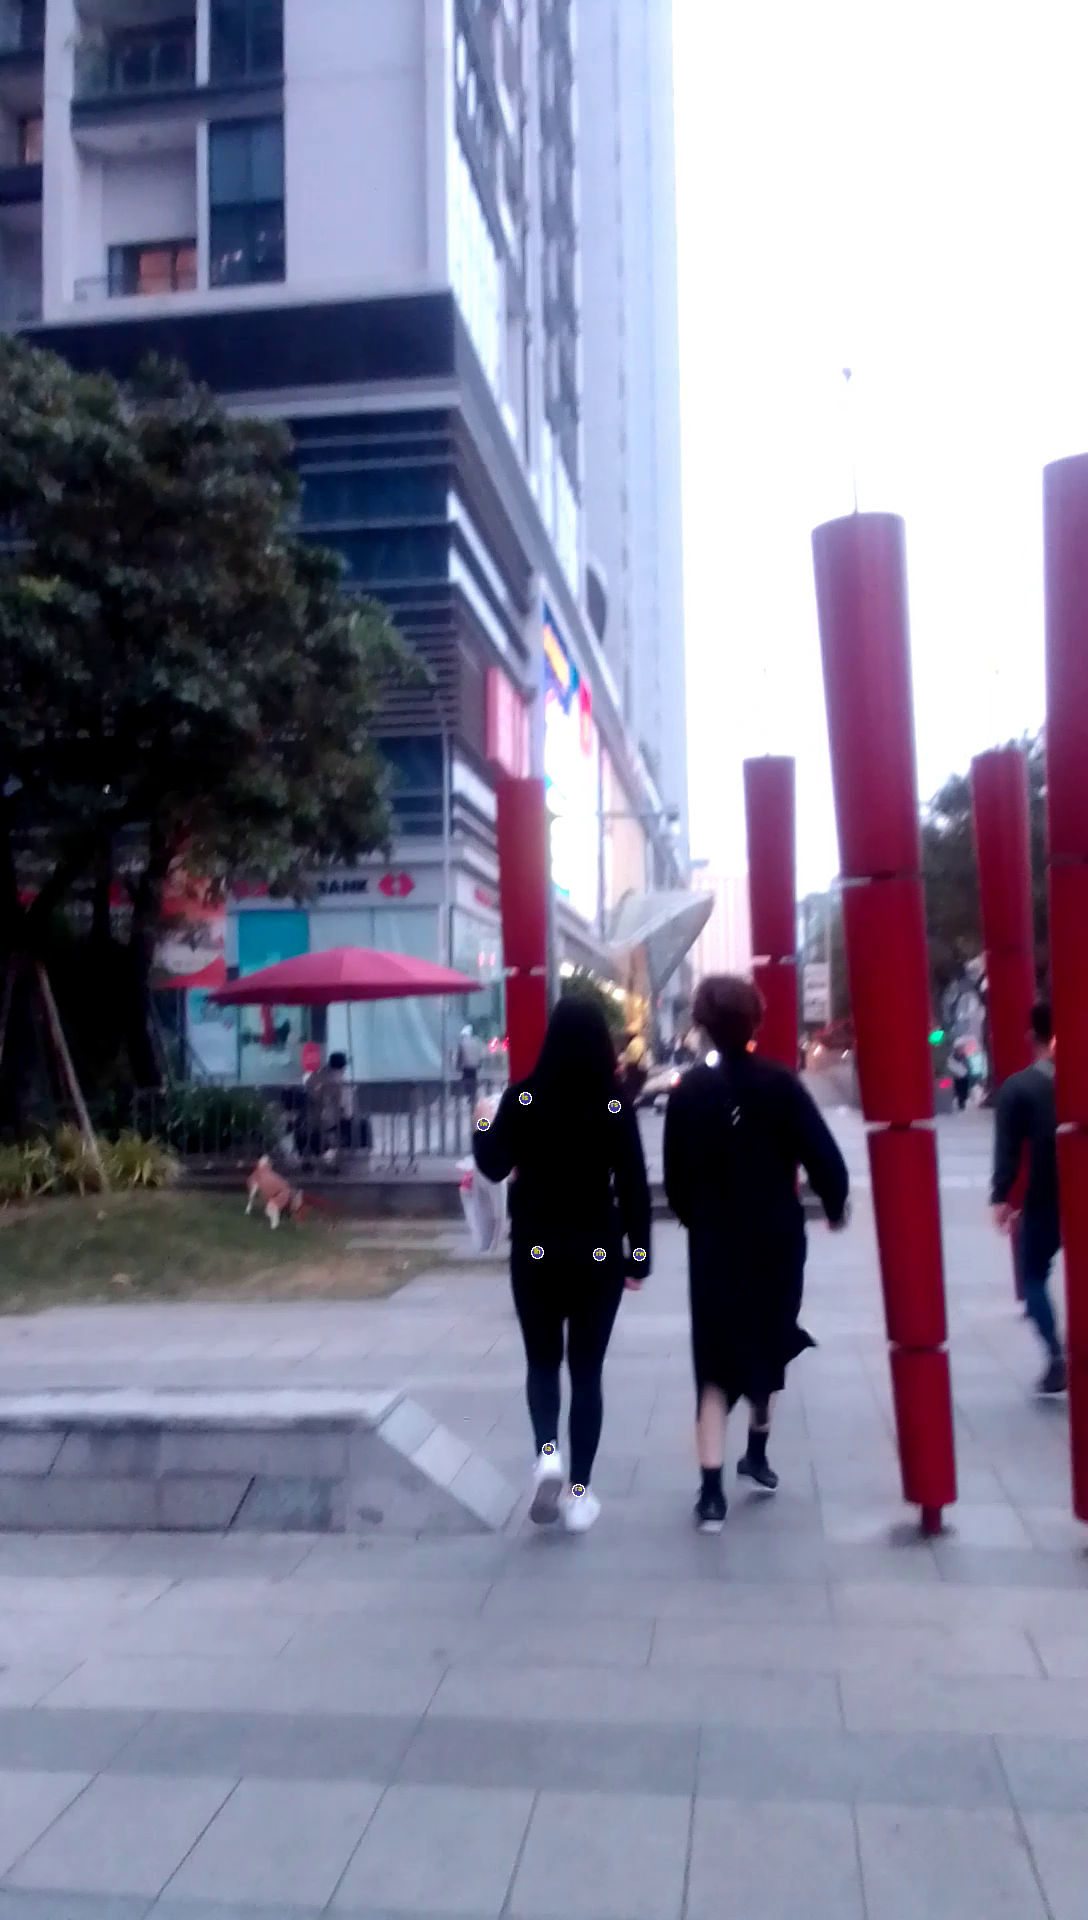

In [156]:
points_image, SHA_points, selected_bbox = detect(sample)
points_image

Found  7  person in the frame
[664.8368530273438, 971.3067016601562, 848.6600952148438, 1525.629638671875]
[468.83929443359375, 988.8145751953125, 656.0203857421875, 1538.2877197265625]
194.9031239785783
Not selected 194.9031239785783
[475.00189208984375, 988.8538818359375, 656.1962280273438, 1542.7305908203125]
[468.83929443359375, 988.8145751953125, 656.0203857421875, 1538.2877197265625]
3.881550532111526
Selected 1
[986.80908203125, 996.9006958007812, 1063.1627197265625, 1405.0245361328125]
[468.83929443359375, 988.8145751953125, 656.0203857421875, 1538.2877197265625]
466.77128623030654
Not selected 466.77128623030654
[303.0967712402344, 1049.2821044921875, 357.3338623046875, 1160.2344970703125]
[468.83929443359375, 988.8145751953125, 656.0203857421875, 1538.2877197265625]
281.3161086664804
Not selected 281.3161086664804
[943.655517578125, 1041.1290283203125, 969.9115600585938, 1113.7647705078125]
[468.83929443359375, 988.8145751953125, 656.0203857421875, 1538.2877197265625]
436.061

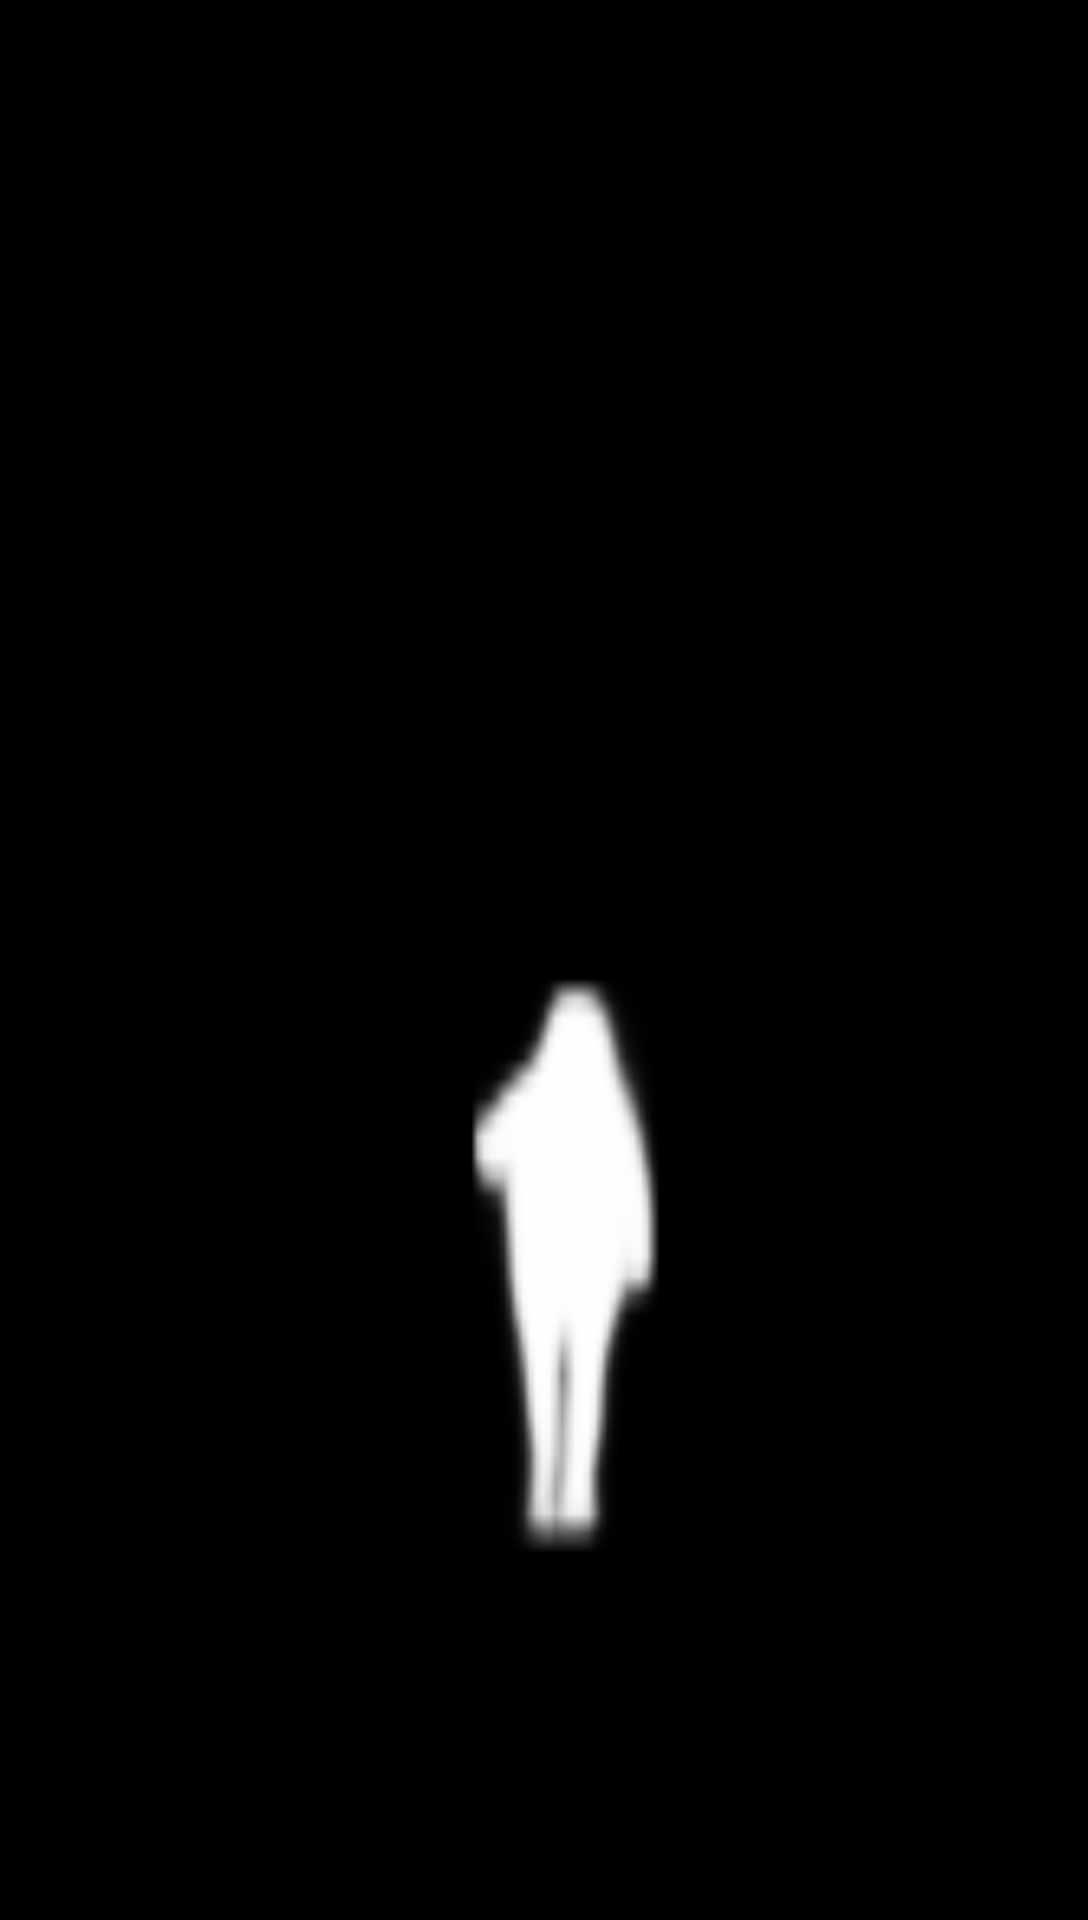

In [157]:
mask, segment_image, bool_mask = segment(sample, selected_bbox)
segment_image